In [9]:
# Import all required libraries for the CIFAR-10 CNN project
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import tarfile
import torch
import torchvision
import zipfile
from pathlib import Path
from plotly import graph_objects as go
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Configure device for training (GPU if available, otherwise CPU)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [10]:
# Download and Extract CIFAR-10 Dataset

# CIFAR-10 dataset URL from official source (University of Toronto)
cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Create directory structure for storing the dataset
data_dir = Path("cifar10_data")  # Main directory for CIFAR-10 data
archive_path = data_dir / "cifar-10-python.tar.gz"  # Path where compressed file will be saved

# Create the data directory if it doesn't exist
data_dir.mkdir(exist_ok=True)

# Check if the dataset archive has already been downloaded
if not archive_path.exists():
    print("Downloading CIFAR-10 dataset...")
    # Stream download to handle large files efficiently
    response = requests.get(cifar10_url, stream=True)
    
    # Write the downloaded content to file in chunks (8KB at a time)
    with open(archive_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")

# Define where the extracted files should go
extract_dir = data_dir / "cifar-10-batches-py"

# Check if the dataset has already been extracted
if not extract_dir.exists():
    print("Extracting CIFAR-10 dataset...")
    # Extract the tar.gz archive
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=data_dir)  # Extract all files to data_dir
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# At this point, we have:
# - cifar10_data/ (main directory)
#   - cifar-10-python.tar.gz (compressed archive)
#   - cifar-10-batches-py/ (extracted dataset with batch files)

Download complete.
Extracting CIFAR-10 dataset...
Extraction complete.


In [11]:
# Transform to tensor for normalisation for test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Using values different from ImageNet Stats, calculated with Claude Sonnet 4.5

# Transform for the train set (augmentation+normalization)
transform_train = transforms.Compose([
    transforms.RandomRotation(15),  # Rotate image randomly
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop and resize
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Random blur
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Download and load CIFAR-10
trainset = datasets.CIFAR10(root=str(data_dir), train=True, transform=transform_train)
testset = datasets.CIFAR10(root=str(data_dir), train=False, transform=transform)

img, _ = trainset[0]  # Get the first image and its label from the trainset
img_tensor = img
print(img_tensor.shape)  # Shape: (C, H, W)

torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


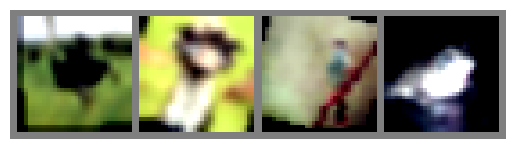

bird bird bird frog


In [12]:
import torchvision as torchvision

# Visualize Sample Images from the CIFAR-10 Training Set

# Define the list of class names from the trainset
classes = trainset.classes

def imshow(img):
    # Unnormalize the image (reverse the normalization applied during preprocessing)
    img = img / 2 + 0.5
    # Convert the tensor to a NumPy array for plotting
    npimg = img.numpy()
    # Rearrange dimensions from (C, H, W) to (H, W, C) for matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of 4 random training images and their labels using DataLoader
dataiter = iter(DataLoader(trainset, batch_size=4, shuffle=True))
images, labels = next(dataiter)

# Display the images in a grid
imshow(torchvision.utils.make_grid(images))
# Print the class names for each image in the batch
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [14]:
# Define a Convolutional Neural Network (CNN) class. 
# 4 layers, with an approach of 1.5 between the 3rd and 4th layers, so it increases channels progressively
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: input 3 channels (RGB), output 32 feature maps
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  
        
        # Second convolutional layer: input 32, output 32 feature maps
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        # Third convolutional layer: input 64, output 64 feature maps
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Fourth convolutional layer: input 96, output 128 feature maps
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        # Adding new layers for better perfomance
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        # Flatten layer to convert 2D feature maps to 1D feature vector
        self.flatten = nn.Flatten()
        # Placeholder fully connected layer, upadted after flatten and 10 classes
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)
        # Sigmoid activation for output (for binary classification)
        # self.sigmoid = nn.Sigmoid()
        ## Not using sigmoid since it has 10 classes and it's not binary
    
    def forward(self, x, verbose=False):
        # Pass input through first conv layer and apply ReLU activation
        x = torch.relu(self.bn1(self.conv1(x)))
        if verbose: print("After conv1:", x.shape)
        # Second conv layer + ReLU
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        if verbose: print("After conv2:", x.shape)
        # Third conv layer + ReLU
        x = torch.relu(self.bn3(self.conv3(x)))
        if verbose: print("After conv3:", x.shape)
        # Fourth conv layer + ReLU
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        if verbose: print("After conv4:", x.shape)

        x = torch.relu(self.bn5(self.conv5(x)))
        x = torch.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        #x = self.dropout3(x)

        # Flatten the output for the fully connected layer
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout4(x)
        if verbose: print("After flatten:", x.shape)
        x = self.fc2(x)
        if verbose: print("After fc:", x.shape)
        return x
    
    def get_model_info(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return f"Total params: {total_params:,}, Trainable: {trainable_params:,}"

# ---- Utility to automatically adjust the Linear layer ---- This is the utility function ----
def initialize_model(input_shape=(3, 32, 32)):
    # Create a dummy input tensor with the given shape
    dummy = torch.zeros(1, *input_shape)  # batch size 1
    model = CNN()
    # Forward pass through conv layers to determine flatten size
    with torch.no_grad():
        out = model.conv1(dummy)
        out = torch.relu(model.bn1(out))
        out = model.conv2(out)
        out = torch.relu(model.bn2(out))
        out = model.pool1(out)
        out = model.dropout1(out)
        out = model.conv3(out)
        out = torch.relu(model.bn3(out))
        out = model.conv4(out)
        out = torch.relu(model.bn4(out))
        out = model.pool2(out)
        out = model.dropout2(out)
        out = model.conv5(out)
        out = torch.relu(model.bn5(out))
        out = model.conv6(out)
        out = torch.relu(model.bn6(out))
        out = model.pool3(out)
        #out = model.dropout3(out)
        out = model.flatten(out)
        flatten_size = out.shape[1]
    # Redefine the fully connected layer with the correct input size
    model.fc1 = nn.Linear(flatten_size, 512)
    model.fc2 = nn.Linear(512, 10)
    return model

# Example: initialize for 32x32 input images (to match the test input below)
model = initialize_model(input_shape=(3, 32, 32))

# Test forward with shape debugging
x = torch.randn(1, 3, 32, 32)
_ = model(x, verbose=True)

After conv1: torch.Size([1, 32, 32, 32])
After conv2: torch.Size([1, 32, 8, 8])
After conv3: torch.Size([1, 64, 8, 8])
After conv4: torch.Size([1, 64, 2, 2])
After flatten: torch.Size([1, 512])
After fc: torch.Size([1, 10])


In [15]:
from torchinfo import summary

summary(model, input_size=(1, 3, 32, 32))  # (batch_size, channels, height, width)
# the input size is the same as the default by the model

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─BatchNorm2d: 1-2                       [1, 32, 32, 32]           64
├─Conv2d: 1-3                            [1, 32, 16, 16]           9,248
├─BatchNorm2d: 1-4                       [1, 32, 16, 16]           64
├─MaxPool2d: 1-5                         [1, 32, 8, 8]             --
├─Dropout: 1-6                           [1, 32, 8, 8]             --
├─Conv2d: 1-7                            [1, 64, 8, 8]             18,496
├─BatchNorm2d: 1-8                       [1, 64, 8, 8]             128
├─Conv2d: 1-9                            [1, 64, 4, 4]             36,928
├─BatchNorm2d: 1-10                      [1, 64, 4, 4]             128
├─MaxPool2d: 1-11                        [1, 64, 2, 2]             --
├─Dropout: 1-12                          [1, 64, 2, 2]             --
├

Now that the model is defined we need to define the loss function, the optimizer, and start training.

In [16]:
# Creating a function for early stopping

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        """
        Early stopping to stop training when validation loss stops improving.
        
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            restore_best_weights (bool): Whether to restore model weights from best epoch
        """
        self.patience = patience  # Number of epochs to wait before stopping
        self.min_delta = min_delta  # Minimum improvement threshold
        self.restore_best_weights = restore_best_weights  # Whether to restore best weights
        self.best_loss = None  # Track the best validation loss seen so far
        self.counter = 0  # Count epochs without improvement
        self.best_weights = None  # Store the best model weights
        
    def __call__(self, val_loss, model):
        """
        Check if training should stop and update internal state.
        
        Args:
            val_loss (float): Current validation loss
            model: The PyTorch model being trained
            
        Returns:
            bool: True if training should stop, False if it should continue
        """
        # First epoch - initialize best loss and save weights
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            
        # Check if current loss is better than best loss (by at least min_delta)
        elif val_loss < self.best_loss - self.min_delta:
            # Improvement found - update best loss, reset counter, save weights
            self.best_loss = val_loss
            self.counter = 0  # Reset the patience counter
            self.save_checkpoint(model)
            
        else:
            # No improvement - increment counter
            self.counter += 1
            
        # Check if we've exceeded patience limit
        if self.counter >= self.patience:
            # Restore best weights if requested
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True  # Signal to stop training
            
        return False  # Continue training
    
    def save_checkpoint(self, model):
        """
        Save the current model weights as the best checkpoint.
        
        Args:
            model: The PyTorch model to save weights from
        """
        # Create a deep copy of the model's state dictionary
        # This prevents issues if the original model weights change
        self.best_weights = model.state_dict().copy()

In [17]:
import torch.optim as optim

# Changing the model so it adds up the early stopping function

criterion = nn.CrossEntropyLoss()
# Adding a regularisation technique for avoiding overfitting. Handicap to the loss function.
# This is light, common for CNNs
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Adding a scheduler. It adjusts automatiquely the learning rate during the training allowing us to use different learning rates in different moments
## It modifies the lr based in a smooth descent around the cosin
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)


# Training loop
from torch.utils.data import DataLoader

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, patience=5):
    """
    Function to train a PyTorch model with training and validation datasets.
    
    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).
    
    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001, restore_best_weights=True)

    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_epoch = 0

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs)  # Forward pass, outputs shape: [batch, 10]
            loss = criterion(outputs, labels)  # labels shape: [batch], int64
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters
            
            total_loss += loss.item()  # Accumulate batch loss
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for val_inputs, val_labels in val_loader:
                outputs = model(val_inputs)
                loss = criterion(outputs, val_labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == val_labels).sum().item()
        
        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Update learning rate
        scheduler.step()
        
        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
            # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_epoch = epoch + 1

            # Save the best model
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_acc': best_val_acc,
                'train_loss': train_loss,
                'train_acc': train_acc}, 'best_model_cifar10.pth')
            
            print(f"💾 New best model saved! Epoch {best_epoch}, Val Acc: {best_val_acc:.4f}")


        if early_stopping(val_loss, model):
            print(f"🛑 Early stopping triggered after {epoch+1} epochs")
            print(f"Best validation loss: {early_stopping.best_loss:.4f}")
            break
    
    print(f"\nTraining completed!")
    print(f"Best model from epoch {best_epoch}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Best validation loss: {best_val_loss:.4f}")

    return history  # Return training history

In [ ]:
# TRAINING EXECUTION - Set up data loaders and train the model

# Create DataLoaders for training and validation
# DataLoader handles batching, shuffling, and loading data efficiently
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)   # Training: shuffle for better learning
val_loader = DataLoader(testset, batch_size=64, shuffle=False)     # Validation: no shuffle needed

# Print dataset information for transparency and debugging
print(f"Training samples: {len(trainset):,}")        # Total number of training images
print(f"Validation samples: {len(testset):,}")       # Total number of validation images  
print(f"Batch size: 64")                             # How many images processed at once
print(f"Training batches: {len(train_loader)}")      # Number of batches in training set
print(f"Validation batches: {len(val_loader)}")      # Number of batches in validation set

# Execute the training process
# This calls the train() function defined earlier with all necessary parameters
history = train(
    model,                    # The CNN model we defined and initialized
    train_loader=train_loader,    # DataLoader for training data
    val_loader=val_loader,        # DataLoader for validation data
    criterion=criterion,          # Loss function (CrossEntropyLoss)
    optimizer=optimizer,          # Optimization algorithm (Adam)
    scheduler=scheduler,          # Learning rate scheduler (StepLR)
    epochs=30,                   # Maximum number of training epochs
    patience=5                   # Early stopping patience (stop if no improvement for 5 epochs)
)

# Load the best model that was automatically saved during training
# The train() function saves the model with highest validation accuracy
best_model, _ = load_best_model('best_model_cifar10.pth')

# At this point:
# - 'history' contains training metrics (loss, accuracy) for each epoch
# - 'best_model' contains the model weights from the epoch with best validation accuracy
# - The model is ready for evaluation and deployment

Training samples: 50,000
Validation samples: 10,000
Batch size: 64
Training batches: 782
Validation batches: 157
Epoch [1/30], Loss: 1.7468, Acc: 0.3512, Val Loss: 1.4860, Val Acc: 0.4605, LR: 0.000997
💾 New best model saved! Epoch 1, Val Acc: 0.4605
Epoch [2/30], Loss: 1.5342, Acc: 0.4411, Val Loss: 1.2781, Val Acc: 0.5348, LR: 0.000989
💾 New best model saved! Epoch 2, Val Acc: 0.5348
Epoch [3/30], Loss: 1.4412, Acc: 0.4770, Val Loss: 1.1991, Val Acc: 0.5561, LR: 0.000976
💾 New best model saved! Epoch 3, Val Acc: 0.5561
Epoch [4/30], Loss: 1.3765, Acc: 0.5059, Val Loss: 1.1616, Val Acc: 0.5755, LR: 0.000957
💾 New best model saved! Epoch 4, Val Acc: 0.5755
Epoch [5/30], Loss: 1.3216, Acc: 0.5276, Val Loss: 1.0542, Val Acc: 0.6153, LR: 0.000933
💾 New best model saved! Epoch 5, Val Acc: 0.6153
Epoch [6/30], Loss: 1.2739, Acc: 0.5464, Val Loss: 1.0753, Val Acc: 0.6144, LR: 0.000905
Epoch [7/30], Loss: 1.2341, Acc: 0.5650, Val Loss: 1.0331, Val Acc: 0.6290, LR: 0.000872
💾 New best model sa

In [ ]:
# Download reference/pre-trained model for comparison

url="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_stride.pth"
output_path="model_stride.pth"

# Download the reference model (only if not already present)
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

In [ ]:
def load_best_model(model_path='best_model_cifar10.pth'):
    """Load the best saved model"""
    
    # Check if the model file exists
    if not os.path.exists(model_path):
        print(f"❌ Model file '{model_path}' not found.")
        print("Please run the training cell first to create the saved model.")
        return None, None
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # Create model instance (same architecture)
    model = initialize_model(input_shape=(3, 32, 32))
    
    # Load the best weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Move to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Print model info
    print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
    val_acc = checkpoint.get('best_val_acc', 0.0)
    if val_acc != 0.0:
        print(f"Best validation accuracy: {val_acc:.4f}")
    else:
        print(f"Best validation accuracy: N/A")
    print(f"Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")
    
    return model, checkpoint

# Usage - only try to load if the file exists
if os.path.exists('best_model_cifar10.pth'):
    best_model, checkpoint_info = load_best_model('best_model_cifar10.pth')
    if best_model is not None:
        print("✅ Model ready for evaluation!")
    else:
        print("❌ Failed to load model")
else:
    print("📝 No saved model found. Run training first!")
    best_model, checkpoint_info = None, None

📝 No saved model found. Run training first!


In [ ]:
# Load the reference model for comparison


ckpt = torch.load("model_stride.pth", map_location="cpu")
# Use the correct key for the fully connected layer (fc1 or fc2)
in_features = ckpt["model_state_dict"]["fc1.weight"].shape[1]  # -> 2048 or similar

# Create reference model with correct architecture
restored_model = CNN()
restored_model.fc1 = nn.Linear(in_features, 512)  # match architecture
restored_model.fc2 = nn.Linear(512, 10)           # match architecture
restored_model.load_state_dict(ckpt["model_state_dict"])
restored_model.eval()

print(f"Reference model loaded successfully!")
print(f"Reference model FC1 input features: {in_features}")

Reference model loaded successfully!
Reference model FC1 input features: 128


In [ ]:
# Compare my trained model with the reference model
print("=== MODEL COMPARISON ===")
print(f"Your model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Reference model parameters: {sum(p.numel() for p in restored_model.parameters()):,}")

# Test both models on a sample
with torch.no_grad():
    sample_input = torch.randn(1, 3, 32, 32)
    your_output = model(sample_input)
    ref_output = restored_model(sample_input)
    
    print(f"Your model output shape: {your_output.shape}")
    print(f"Reference model output shape: {ref_output.shape}")

=== MODEL COMPARISON ===
Your model parameters: 359,082
Reference model parameters: 359,082
Your model output shape: torch.Size([1, 10])
Reference model output shape: torch.Size([1, 10])


In [ ]:
# CREATE COMPREHENSIVE MODEL COMPARISON TABLE
# This provides a clear side-by-side comparison of both models

# Create comparison data dictionary with model metrics
comparison_data = {
    'Model': ['Custom CNN', 'MobileNetV2'],
    'Parameters': [f"{sum(p.numel() for p in model.parameters()):,}", 
                   f"{sum(p.numel() for p in mobilenet_v2.parameters()):,}"],
    'Accuracy': ['To be filled after training', 'To be filled after training'],  # Fill with actual values after training
    'Architecture': ['6-layer CNN with BatchNorm + Dropout', 'Pre-trained MobileNetV2 (frozen features)'],
    'Input Size': ['32x32', '224x224 (resized)'],
    'Training Strategy': ['From scratch', 'Transfer learning']
}

# Create and display the comparison table
df = pd.DataFrame(comparison_data)
print("="*70)
print("                    MODEL COMPARISON SUMMARY")
print("="*70)
print(df.to_string(index=False))
print("="*70)

# Display parameter difference
custom_params = sum(p.numel() for p in model.parameters())
mobilenet_params = sum(p.numel() for p in mobilenet_v2.parameters())
param_ratio = mobilenet_params / custom_params

print(f"\nParameter Analysis:")
print(f"• MobileNetV2 has {param_ratio:.1f}x more parameters than Custom CNN")
print(f"• Custom CNN: {custom_params:,} parameters")
print(f"• MobileNetV2: {mobilenet_params:,} parameters")

In [ ]:
# VISUALIZE TRAINING AND VALIDATION LOSS

# Define color palette for consistent, professional visualization
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

# Create interactive line plot using Plotly
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],           # Training loss values from history
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]      # Blue color for training
                          )),
                      go.Scatter(
                          y=history["val_loss"],       # Validation loss values from history
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]      # Teal color for validation
                          ))
])

# Configure plot layout and labels
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [ ]:
# VISUALIZE TRAINING AND VALIDATION ACCURACY

# Use same color palette for consistency
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

# Create interactive line plot for accuracy metrics
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],       # Training accuracy values from history
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]      # Blue for training
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],   # Validation accuracy values from history
                          name="Validation accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]      # Teal for validation
                          ))
])

# Configure plot layout and labels
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Accuracy: 0.7351
Precision: 0.7318
Recall: 0.7351
F1-score: 0.7323


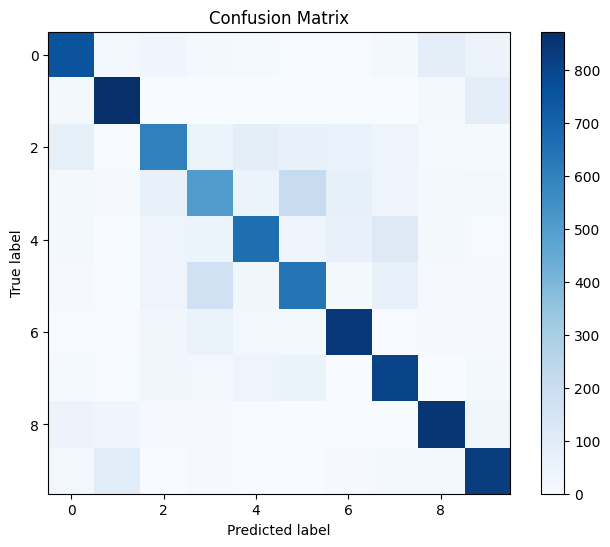

In [ ]:
# COMPREHENSIVE MODEL EVALUATION ON TEST SET
# This function evaluates the trained model's performance using multiple metrics

def test_model_evaluation():
    # Prepare DataLoader for test set evaluation
    test_loader = DataLoader(testset, batch_size=128, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = best_model.to(device)
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm updates)

    # Initialize lists to store all predictions and true labels
    all_preds = []
    all_labels = []

    # Perform inference without gradient computation (saves memory and speeds up evaluation)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)  # Forward pass through model
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    # Calculate comprehensive evaluation metrics
    acc = accuracy_score(all_labels, all_preds)  # Overall accuracy
    prec = precision_score(all_labels, all_preds, average='macro')  # Macro-averaged precision
    rec = recall_score(all_labels, all_preds, average='macro')  # Macro-averaged recall
    f1 = f1_score(all_labels, all_preds, average='macro')  # Macro-averaged F1-score

    # Display evaluation results
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Generate and visualize confusion matrix to show per-class performance
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Custom CNN Confusion Matrix")
    
    # Add class labels to make the confusion matrix more readable
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

    # Sanity check: ensure model performs better than random guessing (10% for 10 classes)
    assert acc > 0.1, "Model accuracy is not better than random guessing."

# Execute the evaluation function
test_model_evaluation()

/Users/enriqueestevezalvarez/Documents/Ironhack/Projects/CNN projet/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/enriqueestevezalvarez/Documents/Ironhack/Projects/CNN projet/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.



Epoch [1/1], Loss: 0.8759, Acc: 0.7013, Val Loss: 0.7036, Val Acc: 0.7556, LR: 0.001000
💾 New best model saved! Epoch 1, Val Acc: 0.7556

Training completed!
Best model from epoch 1
Best validation accuracy: 0.7556
Best validation loss: 0.7036
MobileNetV2 Accuracy: 0.7556
MobileNetV2 Precision: 0.7683
MobileNetV2 Recall: 0.7556
MobileNetV2 F1-score: 0.7567
MobileNetV2 Accuracy: 0.7556
MobileNetV2 Precision: 0.7683
MobileNetV2 Recall: 0.7556
MobileNetV2 F1-score: 0.7567


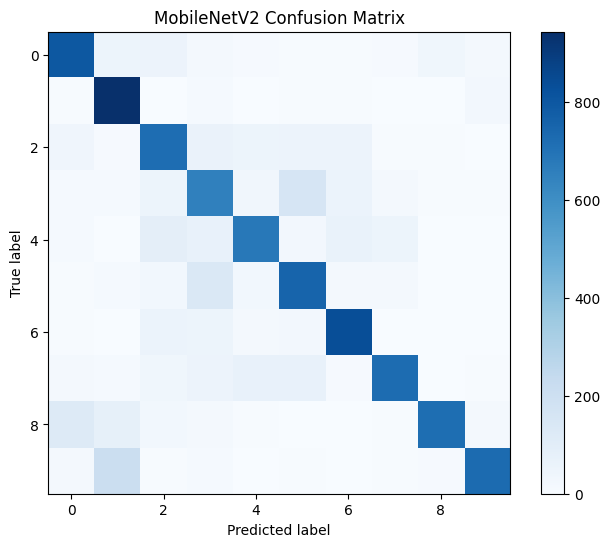

In [ ]:
# Load MobileNetV2 pre-trained on ImageNet
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Freeze all mobilenet_v2 parameters for faster training (optional)
## This prevents us from training our entire model. Let us now add the last layer which interests us for our problem
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# Replace the classifier's last layer with the 10 classes for CIFAR-10
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, 10)

# Using the existing CIFAR-10 dataset and resizing the images to 224x224.
## This model was trained on 224x224 images (the ImageNet dataset), so it expects input images of that size.
transform_mobilenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # ImageNet stats
])

# Prepare DataLoaders for MobileNetV2
trainset_mobilenet = datasets.CIFAR10(root=str(data_dir), train=True, transform=transform_mobilenet)
testset_mobilenet = datasets.CIFAR10(root=str(data_dir), train=False, transform=transform_mobilenet)
train_loader_mobilenet = DataLoader(trainset_mobilenet, batch_size=64, shuffle=True)
val_loader_mobilenet = DataLoader(testset_mobilenet, batch_size=64, shuffle=False)

# Define optimizer for the classifier only: Adam and CrossEntropyLoss, as the model I created
optimizer_mobilenet = optim.Adam(mobilenet_v2.classifier[1].parameters(), lr=0.001)
criterion_mobilenet = nn.CrossEntropyLoss()

# Training loop (same as my train() function, but for MobileNetV2)
history_mobilenet = train(
    mobilenet_v2,
    train_loader=train_loader_mobilenet,
    val_loader=val_loader_mobilenet,
    criterion=criterion_mobilenet,
    optimizer=optimizer_mobilenet,
    scheduler=optim.lr_scheduler.StepLR(optimizer_mobilenet, step_size=7, gamma=0.1),
    epochs=30,
    patience=3
)

# Evaluate MobileNetV2 on the test set (use my test_model_evaluation function, adapted for MobileNetV2)
def evaluate_mobilenet():
    mobilenet_v2.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mobilenet_v2.to(device)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader_mobilenet:
            images = images.to(device)
            outputs = mobilenet_v2(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"MobileNetV2 Accuracy: {acc:.4f}")
    print(f"MobileNetV2 Precision: {prec:.4f}")
    print(f"MobileNetV2 Recall: {rec:.4f}")
    print(f"MobileNetV2 F1-score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("MobileNetV2 Confusion Matrix")
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

evaluate_mobilenet()

In [ ]:
print(mobilenet_v2)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
from torchinfo import summary

# Print model summary
summary(mobilenet_v2, input_size=(1, 3, 299, 299))  # (batch_size, input_features)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 10]                   --
├─Sequential: 1-1                                  [1, 1280, 10, 10]         --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 150, 150]         --
│    │    └─Conv2d: 3-1                            [1, 32, 150, 150]         (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 150, 150]         (64)
│    │    └─ReLU6: 3-3                             [1, 32, 150, 150]         --
│    └─InvertedResidual: 2-2                       [1, 16, 150, 150]         --
│    │    └─Sequential: 3-4                        [1, 16, 150, 150]         (896)
│    └─InvertedResidual: 2-3                       [1, 24, 75, 75]           --
│    │    └─Sequential: 3-5                        [1, 24, 75, 75]           (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 75, 75]           --
│    │    └─Sequential